
<div style="line-height:2px;border: solid orange">
    <p>
    <p style="color:blue;font-family:arial;text-align:right;font-size:20"> Visión por Computador &nbsp;&nbsp;
    <p style="color:blue;font-family:arial;text-align:right;font-size:16"> Master en Ciencias de Datos e Ingeniería de Ordenadores   &nbsp;&nbsp;
  <p style="color:blue;font-family:arial;text-align:right;font-size:16"> Rosa Mª. Rodríguez Sánchez   &nbsp;&nbsp;
    <p style="color:blue;font-family:arial;text-align:right;font-size:10"> Dpto. Ciencias de la Computación e Inteligencia Artificial. &nbsp;&nbsp;
    <p style="color:blue;font-family:arial;text-align:right;font-size:10"> ETSIIT. Universidad de Granada   &nbsp;&nbsp;
        <p>
</div>

# Trabajo 3- Clasificación de peatones

## Autores:
    -  Juan Emilio Martínez Manjón
    -  Antonio David Villegas Yeguas

### Preprocesamiento de la BBDD

In [1]:
# Módulos

import math
import cv2
import os
from sklearn.svm import SVC
import seaborn as sn
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import Model, Sequential
from keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from keras.metrics import BinaryAccuracy
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Dropout, Lambda, BatchNormalization, RandomFlip, RandomRotation
import random
import pandas as pd
import copy
from time import time
random.seed(1234)

In [2]:
# Establecemos una semilla
random.seed(1234)

# Creamos una función que lea todas las imágenes de un directorio
# concreto.
def load_images(directorio, color=0):
    imagenes = []
    for filename in os.listdir(directorio):
        img = cv2.imread(os.path.join(directorio,filename),color)
        if img is not None:
            imagenes.append(img)
    return imagenes

# Leemos las imágenes positivas (con peatones)
X_pos = load_images("data/classification/pedestrians128x64",1)
y_pos = [1 for i in range(0,len(X_pos))]

# Leemos las imágenes negativas (sin peatones)
X_neg = load_images("data/classification/pedestrians_neg",1)
y_nega = [-1 for i in range(0,len(X_neg))]

# El guion de prácticas nos indica que solo debemos usar 400 de las 924
# imágenes positivas. Las escogemos aleatoriamente.
X_pos = random.sample(X_pos, 400)
y_pos = y_pos[0:400]

# El conjunto negativo solo tiene 50 imágenes. Debemos aumentar este conjunto
# hasta llegar a 400. Para ello redimensionaremos las 50 imágenes a un tamaño de
# 512x512. Una vez hecho esto, escogeremos 8 trozos 128x64 de cada imagen
# redimensionada.

# Redimensionamos las imágenes
X_neg_resized = []

for im in X_neg:
    X_neg_resized.append(cv2.resize(im,(512,512)))

# Extraemos 8 trozos 128x64 de cada imagen
X_neg = []

for im in X_neg_resized:
    for i in range (0,8):

        # Escogemos una fila y columna inicial aleatoria
        random_init_row = random.randint(0,512-128)
        random_init_col = random.randint(0,512-64)

        # Extraemos la imagen
        extraida = im[random_init_row:random_init_row+128, random_init_col:random_init_col+64]
        X_neg.append(extraida)

y_nega = [-1 for i in range(0,len(X_neg))]

print("Dimensiones imagenes positivas: ",X_pos[0].shape)
print("Dimensiones imagenes negativas: ",X_neg[0].shape)
print("Numero de imagenes positivas: ",len(X_pos))
print("Numero de imagenes negativas: ",len(X_neg))

Dimensiones imagenes positivas:  (128, 64, 3)
Dimensiones imagenes negativas:  (128, 64, 3)
Numero de imagenes positivas:  400
Numero de imagenes negativas:  400


### Clasificación usando SVM

In [3]:
# Función que calcula el HOG de una imagen
def HOG(imagen):

    # Pasamos la imagen a float (escala 0-1)
    imagen = np.float32(imagen) / 255.0

    # Comenzamos obteniendo las imágenes gradiente. Para ello
    # convolucionamos la imagen con kernels Sobel 1D.

    Gx = cv2.Sobel(imagen, cv2.CV_32F, 1, 0, ksize=1)
    Gy = cv2.Sobel(imagen, cv2.CV_32F, 0, 1, ksize=1)

    # Calculamos la magnitud
    magnitud = np.sqrt(Gx**2 + Gy**2)

    # Calculamos la orientacion
    orientacion = np.abs(np.arctan2(Gy,Gx) * 180/np.pi)

    # Ahora debemos calcular un histograma de orientación de gradiente
    # por cada célula 8x8 de nuestra imagen. Para ello crearemos una
    # matriz de listas que iremos rellenando.

    hog = [[0 for x in range(int(imagen.shape[1] / 8))] for y in range(int(imagen.shape[0] / 8))]

    # Recorremos cada célula
    for indice1,r in enumerate(range(0, imagen.shape[0], 8)):
        for indice2,c in enumerate(range(0, imagen.shape[1], 8)):

            # Inicializamos el hog de la célula actual
            hog_aux = [0.0 for i in range(0,10)]
            hog_angles = [10,30,50,70,90,110,130,150,170,180]
            mag_aux = magnitud[r:r+8,c:c+8,1]
            ori_aux = orientacion[r:r+8,c:c+8,1]

            # Recorremos la célula
            for i in range(mag_aux.shape[0]):
                for j in range(mag_aux.shape[1]):

                    # Vemos cual es el ángulo más cercano de la lista de hog_angles
                    indx = (np.abs(hog_angles - ori_aux[i][j])).argmin()

                    # Si coincide con el ángulo, añadimos la magnitud del pixel al hog
                    if (ori_aux[i][j] == hog_angles[indx]):
                        hog_aux[indx] += mag_aux[i][j]

                    # Si no coincide, dividimos la magnitud entre los ángulos adyacentes
                    else:
                        # Si el ángulo es menor
                        if (ori_aux[i][j] < hog_angles[indx]):

                            hog_aux[indx-1] += mag_aux[i][j]*(hog_angles[indx]-ori_aux[i][j])/(hog_angles[indx] - hog_angles[indx-1])

                            hog_aux[indx] += mag_aux[i][j]*(ori_aux[i][j] - hog_angles[indx-1])/(hog_angles[indx] - hog_angles[indx-1])

                        # Si el ángulo es mayor
                        else:

                            hog_aux[indx] += mag_aux[i][j]*(hog_angles[indx+1]-ori_aux[i][j])/(hog_angles[indx+1] - hog_angles[indx])

                            hog_aux[indx+1] += mag_aux[i][j]*(ori_aux[i][j] - hog_angles[indx])/(hog_angles[indx+1] - hog_angles[indx])

            # Almacenamos en hog los valores de hog_aux
            hog[indice1][indice2] = hog_aux

    # Agrupamos los histogramas/célula en bloques de histogramas. Cada bloque estará formado
    # por 4 células.
    hog_bloques = []
    for i in range(0, int(imagen.shape[0] / 8) - 1):
        for j in range(0, int(imagen.shape[1] / 8) - 1):

            aux = []

            aux = aux + hog[i][j]
            aux = aux + hog[i][j+1]
            aux = aux + hog[i+1][j]
            aux = aux + hog[i+1][j+1]

            hog_bloques.append(aux)

    # Normalizamos el hog por bloques
    for i,bloque in enumerate(hog_bloques):

        # Calculamos el modulo del bloque actual
        modulo = 0.0
        for el in bloque:
            modulo = modulo + el**2

        modulo = math.sqrt(modulo + 0.01)

        # Dividimos el bloque actual entre el módulo
        hog_bloques[i] = [x / modulo for x in bloque]

    # Concatenamos todos los elementos del hog de bloques
    # para obtener el vector de descriptores
    vector_descriptores = [x for l in hog_bloques for x in l]

    # Normalizamos el vector de descriptores
    modulo = 0.0
    for el in vector_descriptores:
        modulo = modulo + el**2

    modulo = math.sqrt(modulo + 0.01)

    # Dividimos cada elemento del vector entre el módulo
    vector_descriptores = [x / modulo for x in vector_descriptores]

    return vector_descriptores



# Creamos HOG_X_pos y HOG_X_neg a partir de X_pos y X_neg.
# Empezamos con HOG_X_pos
HOG_X_pos = []

for imagen in X_pos:
    HOG_X_pos.append(HOG(imagen))

HOG_X_pos = np.array([np.array(xi) for xi in HOG_X_pos])

print("Dimensiones HOG_X_pos: ",HOG_X_pos.shape)


# Ahora HOG_X_neg
HOG_X_neg = []

for imagen in X_neg:
    HOG_X_neg.append(HOG(imagen))

HOG_X_neg = np.array([np.array(xi) for xi in HOG_X_neg])

print("Dimensiones HOG_X_neg: ",HOG_X_neg.shape)

Dimensiones HOG_X_pos:  (400, 4200)
Dimensiones HOG_X_neg:  (400, 4200)


In [4]:
# Establecemos una semilla
random.seed(1234)

# Creamos la matriz X y el vector y
X = np.concatenate([HOG_X_pos,HOG_X_neg])
y = np.concatenate([y_pos,y_nega])

# Hacemos una división en training y test
ntrain = round(0.8*len(y))
ntest = len(X)-ntrain

print("Numero de observaciones training: ",ntrain)
print("Numero de observaciones test: ", ntest)

idx = np.random.permutation(np.arange(len(y)))
X_train= X[idx[0:ntrain],:]
y_train=y[idx[0:ntrain]]
X_test= X[idx[ntrain+1:len(y)],:]
y_test=y[idx[ntrain+1:len(y)]]

Numero de observaciones training:  640
Numero de observaciones test:  160


Accuracy training:  1.0
Accuracy test:  1.0


(<AxesSubplot:title={'center':'Matriz confusión test'}>,
 <AxesSubplot:title={'center':'Matriz confusión test'}>,
 Text(0.5, 1.0, 'Matriz confusión test'))

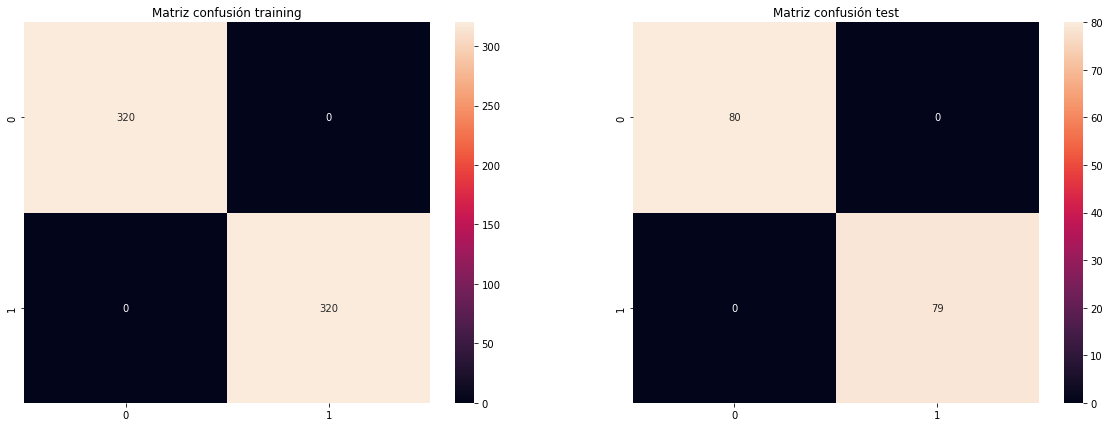

In [5]:
# Creamos un clasificador SVM y lo entrenamos con nuestros datos de
# entrenamiento.

m=SVC()
m.fit(X_train,y_train)

# Predecimos usando los datos de entrenamiento y de test
y_pred_train=m.predict(X_train)
y_pred_test=m.predict(X_test)

# Obtenemos la accuracy en training y en test
training_accuracy = np.sum(y_train == y_pred_train) / len(y_pred_train)
test_accuracy = np.sum(y_test == y_pred_test) / len(y_pred_test)

print("Accuracy training: ",training_accuracy)
print("Accuracy test: ",test_accuracy)

# Mostramos las matrices de confusión
matriz_training = confusion_matrix(y_train,y_pred_train)
matriz_test = confusion_matrix(y_test,y_pred_test)

plt.figure(figsize = (20,7))
plt.subplot(121),sn.heatmap(matriz_training, annot=True,fmt="d"),plt.title('Matriz confusión training')
plt.subplot(122),sn.heatmap(matriz_test, annot=True,fmt="d"),plt.title('Matriz confusión test')

### Clasificación usando CNN

Para este apartado hemos diseñado una función que, dado un modelo base, la capa de entrada, y los conjuntos de entrenamiento, validación y test, entrena una CNN con fine tuning para realizar la clasificación.

In [6]:
## Función que muestra la evolución de las accuracy de train y validación
## durante el entrenamiento.
def mostrar_evolucion(hist):

    loss = hist.history['loss']
    val_loss = hist.history['val_loss']
    plt.plot(loss)
    plt.plot(val_loss)
    plt.legend(['Training loss', 'Validation loss'])
    plt.show()

    acc = hist.history['binary_accuracy']
    val_acc = hist.history['val_binary_accuracy']
    plt.plot(acc)
    plt.plot(val_acc)
    plt.legend(['Training accuracy', 'Validation accuracy'])
    plt.show()

# Función que entrena y calcula las métricas de un modelo usando Fine Tuning
def train_model(base_model, input_layer, training, validation, test, logits=True):

    # Creamos un modelo secuencial que usaremos para Data Augmentation
    data_augmentation = Sequential([
        RandomFlip(),
        RandomRotation(0.1)
    ])

    # Creamos el modelo final
    model = Sequential([
        input_layer,
        data_augmentation,
        base_model,
        BatchNormalization(),
        Dropout(0.2),
        Dense(1)
    ])
    
    print(model.summary())

    # Compilamos el modelo
    model.compile(
        optimizer=Adam(),
        loss=BinaryCrossentropy(from_logits=logits),
        metrics=[BinaryAccuracy()]
    )

    # Entrenamos el modelo usando callbacks para parar de entrenar
    # si la validación se aleja demasiado del entrenamiento
    callback = EarlyStopping(patience=3,restore_best_weights=True)
    start = time()
    history = model.fit(training,
                    epochs=40,
                    validation_data=validation,
                    callbacks=callback)
    first_training_time = time()-start
    mostrar_evolucion(history)

    # Descongelamos el modelo base
    base_model.trainable = True

    # Compilamos el modelo de nuevo usando un learning rate bajo
    model.compile(
        optimizer=Adam(1e-5),
        loss=BinaryCrossentropy(from_logits=logits),
        metrics=[BinaryAccuracy()]
    )

    # Entrenamos el modelo entero
    start = time()
    history = model.fit(training,
                    epochs=100,
                    validation_data=validation,
                    callbacks=callback)
    second_training_time = time()-start
    mostrar_evolucion(history)

    # Predecimos y calculamos una accuracy
    score = model.evaluate(test)

    return first_training_time, second_training_time, score[1], model



Una vez tenemos esta función para entrenar la CNN, vamos a pasar a leer el conjunto de datos como un dataset de TensorFlow:

In [7]:

X = np.concatenate([X_pos,X_neg])
y_nega = [0 for i in range(0,len(y_nega))]
y = np.concatenate([y_pos,y_nega])


# Hacemos una división en training y test
ntrain = round(0.8*len(y))
ntest = len(X)-ntrain


idx = np.random.permutation(np.arange(len(y)))
X_train_val= X[idx[0:ntrain],:]
y_train_val=y[idx[0:ntrain]]
X_test= X[idx[ntrain+1:len(y)],:]
y_test=y[idx[ntrain+1:len(y)]]

ntrain = round(0.8*len(y_train))
nval = len(X_train)-ntrain

idx = np.random.permutation(np.arange(len(y_train_val)))
X_train= X_train_val[idx[0:ntrain],:]
y_train=y_train_val[idx[0:ntrain]]
X_val= X_train_val[idx[ntrain+1:len(y_train_val)],:]
y_val=y_train_val[idx[ntrain+1:len(y_train_val)]]


train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
validation_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))


BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 100

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_dataset = validation_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)



print("Numero de observaciones training: ",ntrain)
print("Numero de observaciones validacion: ",nval)
print("Numero de observaciones test: ", ntest)



Numero de observaciones training:  512
Numero de observaciones validacion:  128
Numero de observaciones test:  160


2022-06-18 12:03:46.053368: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-18 12:03:46.054793: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Una vez tenemos los datos, vamos a probar a utilizar distintos modelos de CNN, comenzando por los básicos, VGG16, ResNet50, ResNet101 y Xception.

In [19]:
modelos = dict()
preprocesado = dict()


modelos["vgg16"] = tf.keras.applications.VGG16(include_top = False, weights = "imagenet",
                                    pooling = "avg")
preprocesado["vgg16"] = Lambda(tf.keras.applications.vgg16.preprocess_input, input_shape = (128,64,3))

modelos["resnet50"] = tf.keras.applications.ResNet50(include_top = False, weights = "imagenet",
                                    pooling = "avg")
preprocesado["resnet50"] = Lambda(tf.keras.applications.resnet50.preprocess_input, input_shape = (128,64,3))

modelos["resnet101"] = tf.keras.applications.ResNet101(include_top = False, weights = "imagenet",
                                    pooling = "avg")
preprocesado["resnet101"] = Lambda(tf.keras.applications.resnet.preprocess_input, input_shape = (128,64,3))

modelos["xception"] = tf.keras.applications.Xception(include_top = False, weights = "imagenet",
                                    pooling = "avg")
preprocesado["xception"] = Lambda(tf.keras.applications.xception.preprocess_input, input_shape = (128,64,3))



for key, modelo in modelos.items():
    modelo.trainable = False


resultados = pd.DataFrame(index = modelos.keys(), columns = ["tiempo_entrenamiento", "tiempo_fine_tuning", "tiempo_total", "test_accuracy"])

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_4 (Lambda)           (None, 128, 64, 3)        0         
                                                                 
 sequential_10 (Sequential)  (None, 128, 64, 3)        0         
                                                                 
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 batch_normalization_13 (Bat  (None, 512)              2048      
 chNormalization)                                                
                                                                 
 dropout_5 (Dropout)         (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 513       
                                                     

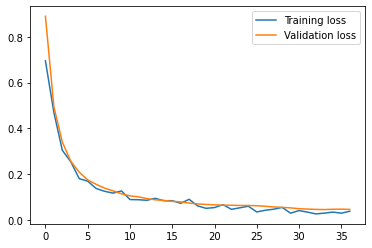

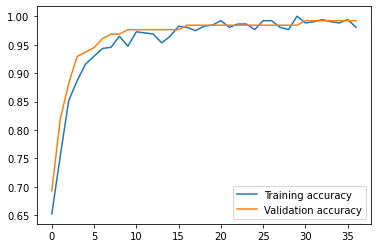

Epoch 1/100
16/16 [==============================] - 33s 2s/step - loss: 0.0270 - binary_accuracy: 0.9961 - val_loss: 0.0373 - val_binary_accuracy: 0.9921
Epoch 2/100
16/16 [==============================] - 33s 2s/step - loss: 0.0128 - binary_accuracy: 0.9961 - val_loss: 0.0469 - val_binary_accuracy: 0.9921
Epoch 3/100
16/16 [==============================] - 31s 2s/step - loss: 0.0060 - binary_accuracy: 1.0000 - val_loss: 0.0322 - val_binary_accuracy: 0.9921
Epoch 4/100
16/16 [==============================] - 34s 2s/step - loss: 0.0042 - binary_accuracy: 1.0000 - val_loss: 0.0127 - val_binary_accuracy: 1.0000
Epoch 5/100
16/16 [==============================] - 32s 2s/step - loss: 0.0047 - binary_accuracy: 1.0000 - val_loss: 0.0097 - val_binary_accuracy: 1.0000
Epoch 6/100
16/16 [==============================] - 32s 2s/step - loss: 9.3184e-04 - binary_accuracy: 1.0000 - val_loss: 0.0086 - val_binary_accuracy: 1.0000
Epoch 7/100
16/16 [==============================] - 32s 2s/step -

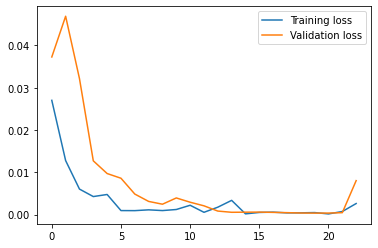

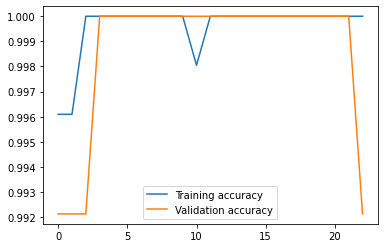

5/5 [==============================] - 2s 469ms/step - loss: 9.7287e-05 - binary_accuracy: 1.0000
Accuracy en test de vgg16: 1.0
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_5 (Lambda)           (None, 128, 64, 3)        0         
                                                                 
 sequential_12 (Sequential)  (None, 128, 64, 3)        0         
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 batch_normalization_14 (Bat  (None, 2048)             8192      
 chNormalization)                                                
                                                                 
 dropout_6 (Dropout)         (None, 2048)              0         
                                                        

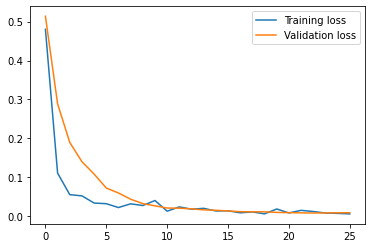

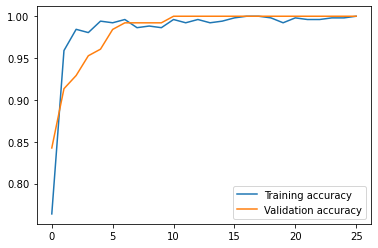

Epoch 1/100
16/16 [==============================] - 29s 2s/step - loss: 0.0545 - binary_accuracy: 0.9766 - val_loss: 0.0071 - val_binary_accuracy: 1.0000
Epoch 2/100
16/16 [==============================] - 24s 2s/step - loss: 0.0322 - binary_accuracy: 0.9902 - val_loss: 0.0074 - val_binary_accuracy: 1.0000
Epoch 3/100
16/16 [==============================] - 24s 2s/step - loss: 0.0325 - binary_accuracy: 0.9883 - val_loss: 0.0076 - val_binary_accuracy: 1.0000
Epoch 4/100
16/16 [==============================] - 25s 2s/step - loss: 0.0276 - binary_accuracy: 0.9941 - val_loss: 0.0071 - val_binary_accuracy: 1.0000


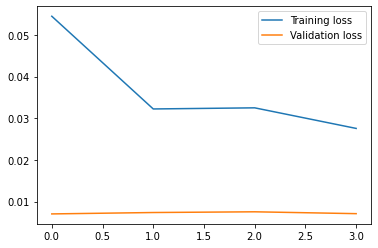

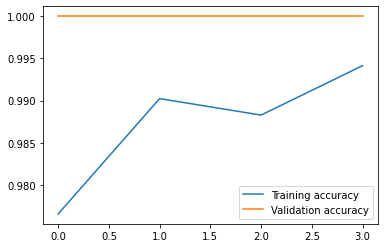

5/5 [==============================] - 2s 351ms/step - loss: 0.0033 - binary_accuracy: 1.0000
Accuracy en test de resnet50: 1.0
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_6 (Lambda)           (None, 128, 64, 3)        0         
                                                                 
 sequential_14 (Sequential)  (None, 128, 64, 3)        0         
                                                                 
 resnet101 (Functional)      (None, 2048)              42658176  
                                                                 
 batch_normalization_15 (Bat  (None, 2048)             8192      
 chNormalization)                                                
                                                                 
 dropout_7 (Dropout)         (None, 2048)              0         
                                                         

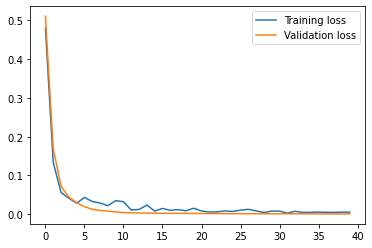

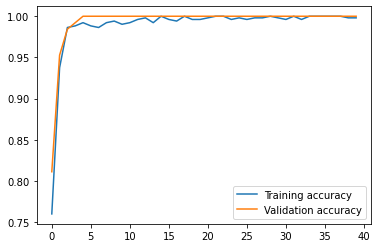

Epoch 1/100
16/16 [==============================] - 46s 3s/step - loss: 0.0305 - binary_accuracy: 0.9883 - val_loss: 0.0019 - val_binary_accuracy: 1.0000
Epoch 2/100
16/16 [==============================] - 41s 3s/step - loss: 0.0102 - binary_accuracy: 1.0000 - val_loss: 0.0043 - val_binary_accuracy: 1.0000
Epoch 3/100
16/16 [==============================] - 39s 2s/step - loss: 0.0130 - binary_accuracy: 0.9980 - val_loss: 0.0052 - val_binary_accuracy: 1.0000
Epoch 4/100
16/16 [==============================] - 40s 2s/step - loss: 0.0177 - binary_accuracy: 0.9941 - val_loss: 0.0051 - val_binary_accuracy: 1.0000


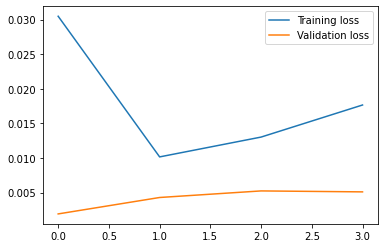

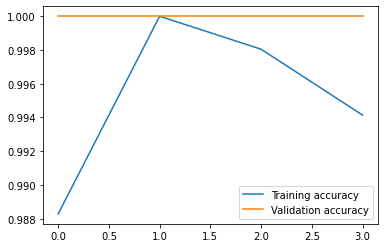

5/5 [==============================] - 3s 606ms/step - loss: 0.0032 - binary_accuracy: 1.0000
Accuracy en test de resnet101: 1.0
Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_7 (Lambda)           (None, 128, 64, 3)        0         
                                                                 
 sequential_16 (Sequential)  (None, 128, 64, 3)        0         
                                                                 
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 batch_normalization_16 (Bat  (None, 2048)             8192      
 chNormalization)                                                
                                                                 
 dropout_8 (Dropout)         (None, 2048)              0         
                                                        

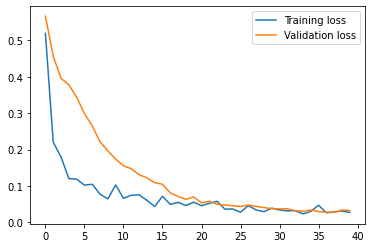

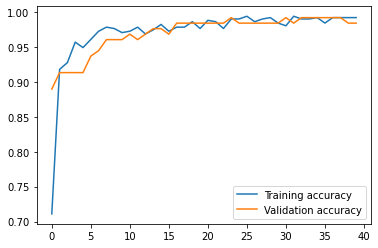

Epoch 1/100
16/16 [==============================] - 28s 2s/step - loss: 0.2799 - binary_accuracy: 0.8867 - val_loss: 0.0386 - val_binary_accuracy: 0.9843
Epoch 2/100
16/16 [==============================] - 25s 2s/step - loss: 0.1572 - binary_accuracy: 0.9473 - val_loss: 0.0420 - val_binary_accuracy: 0.9843
Epoch 3/100
16/16 [==============================] - 24s 2s/step - loss: 0.1393 - binary_accuracy: 0.9453 - val_loss: 0.0421 - val_binary_accuracy: 0.9921
Epoch 4/100
16/16 [==============================] - 25s 2s/step - loss: 0.1440 - binary_accuracy: 0.9512 - val_loss: 0.0402 - val_binary_accuracy: 0.9921


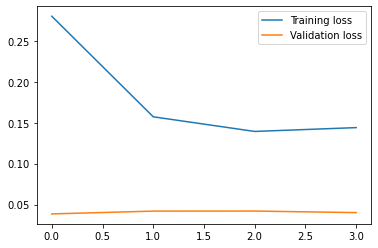

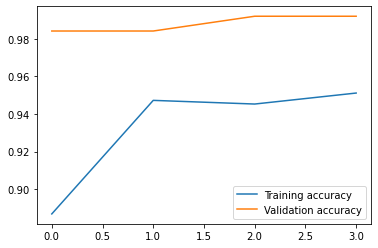

5/5 [==============================] - 2s 364ms/step - loss: 0.0274 - binary_accuracy: 0.9937
Accuracy en test de xception: 0.9937106966972351


In [20]:
for key, modelo in modelos.items():
    
    first_training_time, second_training_time, test_accuracy, modelo_resnet = train_model(modelo, preprocesado[key], 
                                                                                   train_dataset,
                                                                                   validation_dataset,
                                                                                   test_dataset)
    
    resultados.at[key, "tiempo_entrenamiento"] = first_training_time
    resultados.at[key, "tiempo_fine_tuning"] = second_training_time
    resultados.at[key, "tiempo_total"] = first_training_time + second_training_time
    resultados.at[key, "test_accuracy"] = test_accuracy
    
    print("Accuracy en test de {}: {}".format(key, test_accuracy))


In [21]:
resultados

,tiempo_entrenamiento,tiempo_fine_tuning,tiempo_total,test_accuracy
vgg16,426.560624,760.941041,1187.501665,1.0
resnet50,223.633373,101.97503,325.608403,1.0
resnet101,658.129778,165.677342,823.80712,1.0
xception,330.609606,117.434843,448.044449,0.993711


<AxesSubplot:title={'center':'Comparación de la tasa de acierto en el conjunto de test'}>

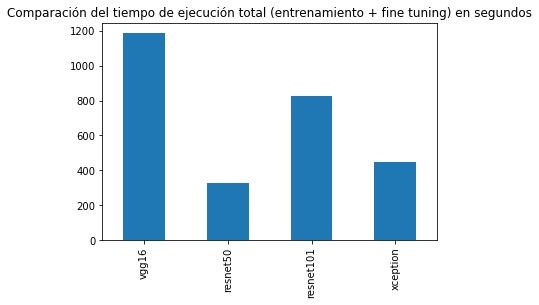

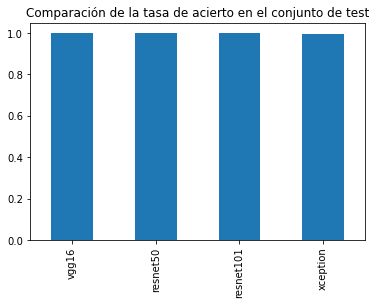

In [22]:
resultados.plot(y = "tiempo_total", kind = "bar", title = "Comparación del tiempo de ejecución total (entrenamiento + fine tuning) en segundos", legend = False)
resultados.plot(y = "test_accuracy", kind = "bar", title = "Comparación de la tasa de acierto en el conjunto de test", legend = False)

En este caso todos los modelos han obtenido una tasa de acierto del 100%, al igual que SVC, por este motivo, creemos que no es interesante contemplar estos modelos ya que el tiempo de entrenamiento es demasiado alto, y conseguimos los mismos resultados con un modelo clásico como es SVC.